In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, date
import time

In [2]:
# sanity check get total number of fatalities
df = pd.read_csv('../FARS2019NationalCSV/Person.CSV', encoding="ISO-8859-1")
df = df.loc[df['INJ_SEV'] == 4]
print(len(df))
df.head(5)

36355


/var/folders/rv/4pnymp6j7bd30dklzsj4ykr40000gn/T/ipykernel_64937/1663778059.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../FARS2019NationalCSV/Person.CSV', encoding="ISO-8859-1")


,STATE,STATENAME,ST_CASE,VE_FORMS,VEH_NO,PER_NO,STR_VEH,COUNTY,DAY,DAYNAME,...,WORK_INJ,WORK_INJNAME,HISPANIC,HISPANICNAME,LOCATION,LOCATIONNAME,HELM_USE,HELM_USENAME,HELM_MIS,HELM_MISNAME
1,1,Alabama,10001,2,1,2,0,81,7,7,...,0,No,7,Non-Hispanic,0,Occupant of a Motor Vehicle,20,Not Applicable,7,None Used/Not Applicable
3,1,Alabama,10002,2,1,1,0,55,23,23,...,0,No,7,Non-Hispanic,0,Occupant of a Motor Vehicle,20,Not Applicable,7,None Used/Not Applicable
6,1,Alabama,10003,3,1,2,0,29,22,22,...,0,No,7,Non-Hispanic,0,Occupant of a Motor Vehicle,20,Not Applicable,7,None Used/Not Applicable
9,1,Alabama,10004,1,0,1,1,55,22,22,...,0,No,7,Non-Hispanic,11,"Not at Intersection - On Roadway, Not in Marke...",96,Not a Motor Vehicle Occupant,8,Not a Motor Vehicle Occupant
11,1,Alabama,10005,1,1,1,0,3,18,18,...,0,No,7,Non-Hispanic,0,Occupant of a Motor Vehicle,20,Not Applicable,7,None Used/Not Applicable


### Get fatalities

In [52]:
# get fatalities of only when there are multiple people in vehicle
df1 = pd.read_csv('../FARS2019NationalCSV/vehicle.csv', encoding="ISO-8859-1")
print(len(df1))
df1 = df1.loc[df1['NUMOCCS'] > 1]
print(len(df1))
df2 = pd.read_csv('../FARS2019NationalCSV/Person.CSV', encoding="ISO-8859-1")
df2 = df2[df2['ST_CASE'].isin(df1['ST_CASE'].values.tolist())]
df = df2.loc[df2['INJ_SEV'] == 4]
print(df['INJ_SEV'][0:20])
print(df['DOA'][0:20]) # dead on arrival
print(len(df))

/var/folders/rv/4pnymp6j7bd30dklzsj4ykr40000gn/T/ipykernel_68413/2660047324.py:2: DtypeWarning: Columns (56,58,193,195) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('../FARS2019NationalCSV/vehicle.csv', encoding="ISO-8859-1")


51623
15711
1      4
6      4
18     4
21     4
23     4
46     4
64     4
78     4
85     4
98     4
101    4
104    4
108    4
110    4
113    4
114    4
118    4
120    4
139    4
145    4
Name: INJ_SEV, dtype: int64
1      7
6      7
18     0
21     7
23     0
46     0
64     7
78     7
85     7
98     0
101    0
104    7
108    0
110    7
113    7
114    7
118    0
120    7
139    0
145    7
Name: DOA, dtype: int64
16125


/var/folders/rv/4pnymp6j7bd30dklzsj4ykr40000gn/T/ipykernel_68413/2660047324.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('../FARS2019NationalCSV/Person.CSV', encoding="ISO-8859-1")


## Graphs about the dataset
#### Graphs about time of crashes and time of death

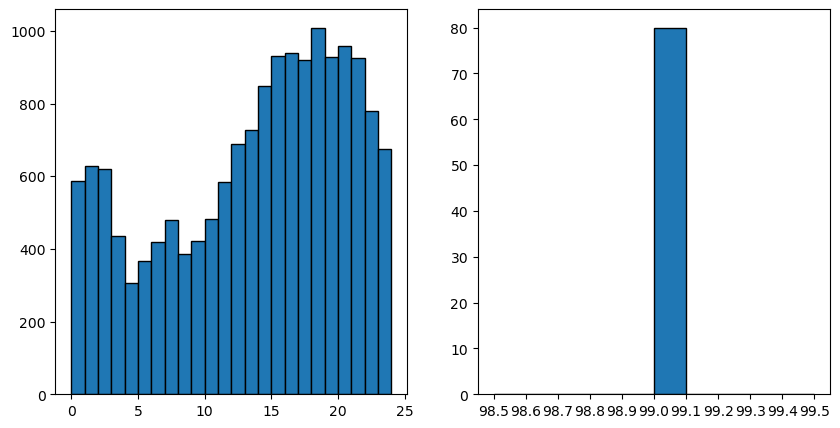

In [4]:
# create graph to display time of day crash occurred
df_hour = df['HOUR']
df_hour = df_hour.loc[df_hour <= 24] # dropout unknown crash times to get cleaner histogram

df_unknown_hour = df['HOUR']
df_unknown_hour = df_unknown_hour.loc[df_unknown_hour > 24]

fig,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist(df_hour, range(0,25),edgecolor = "black")
_,bins,_ = ax[1].hist(df_unknown_hour, edgecolor="black")
ax[1].set_xticks(bins);

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


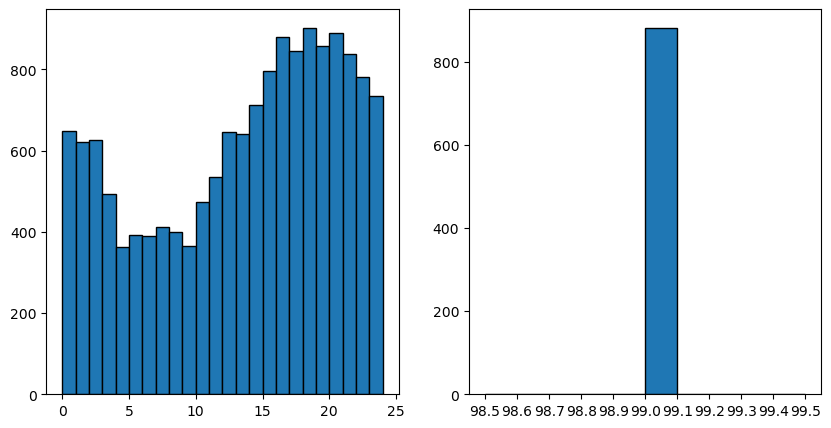

In [5]:
# graph of time of death -- including deaths on arrival
df_hour = df['DEATH_HR']
df_hour = df_hour.loc[df_hour <= 24] # dropout unknown crash times to get cleaner histogram

df_unknown_hour = df['DEATH_HR']
df_unknown_hour = df_unknown_hour.loc[df_unknown_hour > 24]

fig,ax = plt.subplots(1,2, figsize=(10,5))
_,bins,_ = ax[0].hist(df_hour, range(0,25),edgecolor = "black")
print(bins)
_,bins,_ = ax[1].hist(df_unknown_hour, edgecolor="black")
ax[1].set_xticks(bins);

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


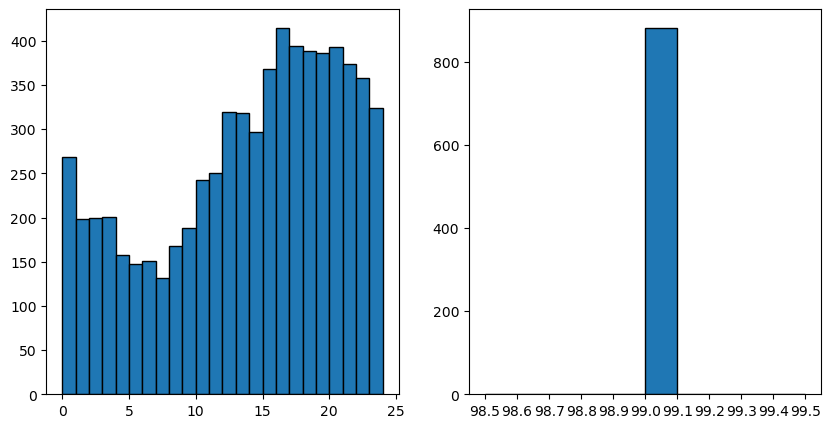

In [6]:
# graph of time of death -- excluding deaths on arrival
df_hour = df.loc[df['DOA'] != 7]
df_hour = df_hour['DEATH_HR']
df_hour = df_hour.loc[df_hour <= 24] # dropout unknown crash times to get cleaner histogram

df_unknown_hour = df.loc[df['DOA'] != 7]
df_unknown_hour = df['DEATH_HR']
df_unknown_hour = df_unknown_hour.loc[df_unknown_hour > 24]

fig,ax = plt.subplots(1,2, figsize=(10,5))
_,bins,_ = ax[0].hist(df_hour, range(0,25),edgecolor = "black")
print(bins)
_,bins,_ = ax[1].hist(df_unknown_hour, edgecolor="black")
ax[1].set_xticks(bins);

Note:
0 -- made it to hospital 6978.0 
7 -- dead on arrival 9001.0 
8 -- died in trasit 121.0 
9 -- Unknown 25.0


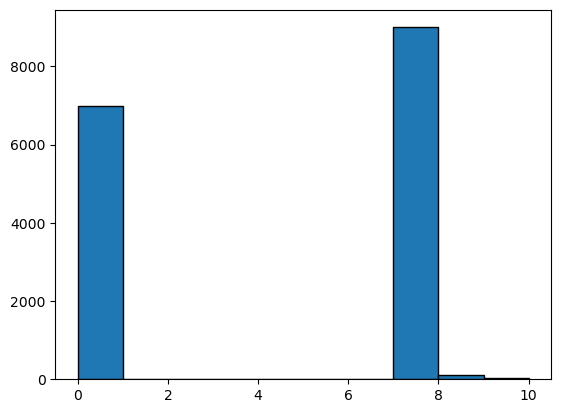

In [10]:
# graph of Dead on Arrival
arr = plt.hist(df['DOA'], range(0,11),edgecolor="black")
arr = arr[0]
print('Note:\n0 -- made it to hospital', arr[0], '\n7 -- dead on arrival', arr[7], '\n8 -- died in trasit', arr[8], '\n9 -- Unknown', arr[9])

#### ejection stats

[ 0  1  2  3  4  5  6  7  8  9 10]


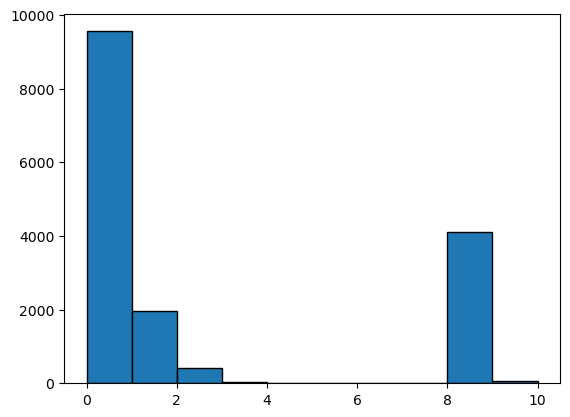

In [18]:
# 
df_ejected = df['EJECTION']
_,bins,_ = plt.hist(df_ejected, range(0,11),edgecolor = "black")
print(bins)

### Print out some statistics about the dataset

Look at individual statistics and see what can be used.

> Need to narrow down some of the variables

##### somethings to possible look at
- the time of survival for ejections
- how likely is someone to survive if they are ejected
- heatmap that shows DOA, ejections, rollovers

mean:  1.021272365805169
std:  3.3776265735595965
var:  11.408361270415941


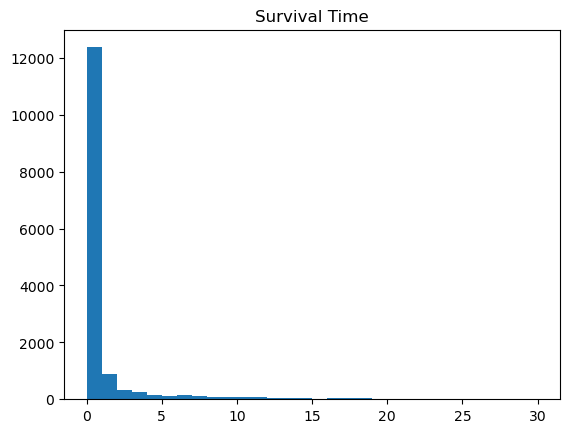

In [50]:
# cell is used to calculate survival time of all occurrances
# structure of time MMDDHHMM
df_crash_times = df.loc[df['HOUR'] != 99] # drop unknown times
df_crash_times = df_crash_times.loc[(df_crash_times['DEATH_HR'] != 99) & (df_crash_times['DEATH_MO'] != 99) & (df_crash_times['DEATH_MN'] != 99)]
# df_crash_times = pd.DataFrame(crash_dict)
df_crash_times['combined'] = "2019 " + df_crash_times['MONTH'].astype(str) + " " + df_crash_times['DAY'].astype(str) + " 2019 " + df_crash_times['DEATH_MO'].astype(str) + " " + df_crash_times['DEATH_DA'].astype(str)# + " " + df_crash_times['HOUR'].astype(str) + " " + df_crash_times['MINUTE'].astype(str)

crash_times = []
day_diff = []
for i in df_crash_times['combined']:
    date_split = i.split()
    day_diff.append((date(2019, int(date_split[4]), int(date_split[5])) - date(2019, int(date_split[1]), int(date_split[2]))).days)
#     crash_times.append(datetime.timestamp(datetime.strptime(i, "%Y %m %d %H %M")))
day_diff = np.array(day_diff)
day_diff = day_diff[day_diff >= 0]
"""
df_crash_times['combined_death'] = "2019 " + df_crash_times['DEATH_MO'].astype(str) + " " + df_crash_times['DEATH_DA'].astype(str) + " " + df_crash_times['DEATH_HR'].astype(str) + " " + df_crash_times['DEATH_MN'].astype(str)
death_times = []
for i in df_crash_times['combined_death']:
    death_times.append(datetime.timestamp(datetime.strptime(i, "%Y %m %d %H %M")))

diff_times = []
for i in range(0, len(death_times)):
    print(death_times[i])
    diff_times.append(date(death_times[i]) - date(crash_times[i]))
"""
plt.hist(day_diff, 30)
plt.title("Survival Time")
print("mean: ", np.mean(day_diff))
print("std: ", np.std(day_diff))
print("var: ", np.var(day_diff))

In [22]:
# average age 
df['AGE'].loc[df['AGE'] < 125].describe()

count    16093.000000
mean        43.108432
std         22.001324
min          0.000000
25%         25.000000
50%         40.000000
75%         60.000000
max        105.000000
Name: AGE, dtype: float64

Note:
0 -- made it to hospital
7 -- dead on arrival
8 -- died in trasit


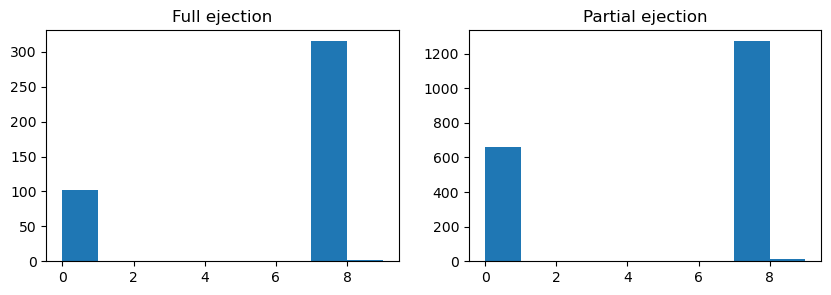

In [18]:
# amount of people who died at the scene after ejection
df_fulleject = df.loc[(df['EJECTION'] == 2) & (df['DOA'] != 9)]
fig,ax = plt.subplots(1,2, figsize=(10,3))
print('Note:\n0 -- made it to hospital\n7 -- dead on arrival\n8 -- died in trasit')
ax[0].hist(df_fulleject['DOA'], range(0,10));
ax[0].title.set_text('Full ejection')
df_fulleject = df.loc[(df['EJECTION'] == 1) & (df['DOA'] != 9)]
ax[1].hist(df_fulleject['DOA'], range(0,10));
ax[1].title.set_text('Partial ejection')

Note:
0 -- made it to hospital
7 -- dead on arrival
8 -- died in trasit



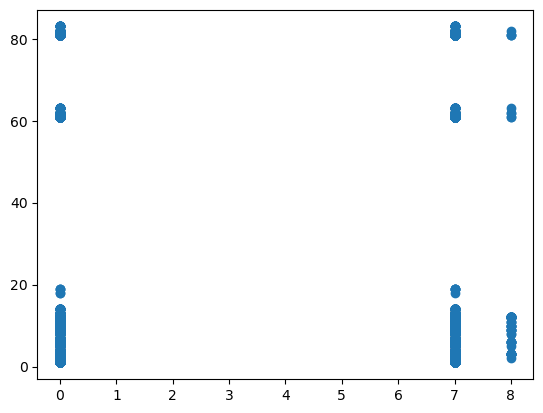

In [27]:
# display simple stats about collision location and death rate
df_collision = df.loc[(df['IMPACT1'] != 0) & (df['IMPACT1'] != np.NaN) & (df['IMPACT1'] != 99) & (df['IMPACT1'] != 98) & (df['DOA'] != 9)]
print('x-axis:\n0 -- made it to hospital\n7 -- dead on arrival\n8 -- died in trasit\n')
print('\ny-axis:\n')
plt.scatter(df_collision['DOA'],df_collision['IMPACT1'])

## Get severely injured occupants of vehicles but survived

In [12]:
# get fatalities of only when there are multiple people in vehicle
df1 = pd.read_csv('../FARS2019NationalCSV/vehicle.csv', encoding="ISO-8859-1")
df1 = df1.loc[df1['NUMOCCS'] > 1]
df2 = pd.read_csv('../FARS2019NationalCSV/Person.CSV', encoding="ISO-8859-1")
df2 = df2[df2['ST_CASE'].isin(df1['ST_CASE'].values.tolist())]
df_survived = df2.loc[(df2['INJ_SEV'] == 2) | (df2['INJ_SEV'] == 3) | (df2['INJ_SEV'] == 0) | (df2['INJ_SEV'] == 1)]
print(df_survived['ST_CASE'][0:20])
print(df_survived['INJ_SEV'][0:20])
print(df_survived['DOA'][0:20]) # dead on arrival
print(len(df_survived))

/var/folders/rv/4pnymp6j7bd30dklzsj4ykr40000gn/T/ipykernel_67949/2705294315.py:2: DtypeWarning: Columns (56,58,193,195) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('../FARS2019NationalCSV/vehicle.csv', encoding="ISO-8859-1")


15711
0     10001
2     10001
5     10003
7     10003
8     10003
14    10007
15    10007
16    10007
17    10007
22    10010
24    10011
25    10011
47    10023
48    10023
65    10033
66    10033
67    10033
77    10042
79    10042
80    10043
Name: ST_CASE, dtype: int64
0     3
2     1
5     2
7     0
8     0
14    2
15    3
16    1
17    1
22    0
24    2
25    3
47    1
48    3
65    1
66    0
67    0
77    3
79    3
80    0
Name: INJ_SEV, dtype: int64
0     0
2     0
5     0
7     0
8     0
14    0
15    0
16    0
17    0
22    0
24    0
25    0
47    0
48    0
65    0
66    0
67    0
77    0
79    0
80    0
Name: DOA, dtype: int64
32862


/var/folders/rv/4pnymp6j7bd30dklzsj4ykr40000gn/T/ipykernel_67949/2705294315.py:5: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('../FARS2019NationalCSV/Person.CSV', encoding="ISO-8859-1")


### Data Notes

Things that might be helpful to use as variable

- collision location
- rollover
- ejection
- speed if available
- airbag deployed or not
